# Central RL control notebook

In [1]:
import sys
from pymgrid import MicrogridGenerator as mg
import matplotlib.pyplot as plt
import numpy as np
import os
import time
from IPython.display import display,clear_output
import pandas as pd
import torch

Time span constants

In [2]:
YEAR = 31579200
MONTH = 2570400
WEEK = 604800
DAY = 86400
HOUR = 3600
MINUTE = 60

In [3]:
rand_weak_grid = np.random.randint(low=0, high=3)
print(rand_weak_grid)

2


### Generate Microgrids

In [4]:
env = mg.MicrogridGenerator(nb_microgrid=2)
#env.grid_type_list = ['weak', 'weak']
env.generate_microgrid(verbose= False, interpolate = True)#len(env.grid_type_list))



In [5]:
env.print_mg_parameters()

load  cost_loss_load  cost_overgeneration  cost_co2  PV_rated_power  \
0    960              10                    1       0.1          969.60   
1  44231              10                    1       0.1        22557.81   

   battery_soc_0  battery_power_charge  battery_power_discharge  \
0        0.00001                   430                      430   
1        0.00001                 19779                    19779   

   battery_capacity  battery_efficiency  battery_soc_min  battery_soc_max  \
0              1718                 0.9          0.00001                1   
1             79115                 0.9          0.00001                1   

   battery_cost_cycle  grid_weak  grid_power_import  grid_power_export  \
0                0.02          0               1920               1920   
1                0.02          1              88462              88462   

   genset_polynom_order  genset_polynom_0  genset_polynom_1  genset_polynom_2  \
0                   NaN               NaN               NaN               NaN   
1                   3.0          4.181674          0.209856          0.043527   

   genset_rated_power  genset_pmin  genset_pmax  fuel_cost  genset_co2  
0                 NaN          NaN          NaN        NaN         NaN  
1             49146.0         0.05          0.9        0.4         2.0

In [6]:
print(env.nb_microgrids)
mg0 = env.microgrids[0]
mg1 = env.microgrids[1]
# mg2 = env.microgrids[2]
print(mg1.parameters['battery_capacity'])

2
0    79115
Name: battery_capacity, dtype: int64


In [7]:
print(mg1.parameters['battery_capacity'])

0    79115
Name: battery_capacity, dtype: int64


525541


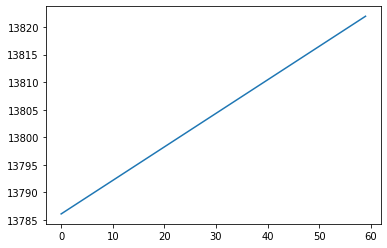

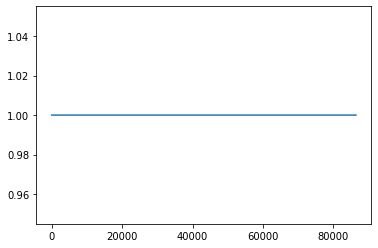

In [8]:
mg0_status = mg0._grid_status_ts
mg1_status = mg1._load_ts
print(len(mg1_status))
plt.plot(mg1_status[0:60])
plt.show()
plt.plot(mg0_status[0:DAY])
plt.show()

In [9]:
mg0.get_control_dict()

['load',
 'pv_consummed',
 'pv_curtailed',
 'pv',
 'battery_charge',
 'battery_discharge',
 'grid_import',
 'grid_export']

In [25]:
# Grid is up

    # PV is above load
        # Battery full
            # action 0: grid up, export, battery full, pv > load
        # Battery empty
            # action 1: grid up, charge w/ genset, battery empty, pv > load
        # Battery not at full charge
            # action 2: grid up, charge w/ pv, battery < full, pv > load

    # PV is below load
        # Battery full
            # action 3: grid up, discharge, battery full, pv < load
        # Battery empty
            # action 4: grid up, import, battery empty, pv < load
                # import + charge until battery > 15%
        # Battery not at full charge
            # action 5: grid up, discharge, battery < full charge, pv < load
                # discharge if battery > 75 %
                # charge if battery < 15%

# Grid is down

    # PV is above load
        # Battery full
            # action 6: grid down, use pv, battery full, pv > load
        # Battery empty
            # action 7: grid down, charge w/ pv, battery empty, pv > load
        # Battery not at full charge
            # action 8: grid down, charge w/ pv, battery < full, pv > load

    # PV is below load
        # Battery full
            # action 9: grid down, discharge, battery full, pv > load
        # Battery empty
            # action 10: grid down, genset, battery empty, pv > load
        # Battery not at full charge
            # action 11: grid down, discharge, battery < full, pv > load

# Stock control dict

# control_dict = {'pv_consummed': min(pv,load),
#                             'battery_charge': 0,
#                             'battery_discharge': 0,
#                             'grid_import': 0,
#                             'grid_export':0,
#                             'genset': 0
#                            }

def actions_agent(mg0, action):
 
    
    pv = round(mg0.pv)
    load = round(mg0.load)
    soc = round(mg0.battery.soc,2)
    capa_total = round(mg0.battery.capacity,2)
    p_charge_max = round(mg0.battery.p_charge_max,2)
    p_discharge_max = round(mg0.battery.p_discharge_max,2)

          
    if action == 0:
        # Grid is up
        # PV is above load
        # Battery full
        # action 0: grid up, export, battery full, pv > load
        control_dict =  {   'pv_consummed': abs(load),
                            'battery_charge': 0,
                            'battery_discharge': 0,
                            'grid_import': 0,
                            'grid_export': pv-abs(load),
                            'genset': 0
                        }

    elif action == 1:
        # Grid is up
        # PV is above load
        # Battery empty
        # action 1: grid up, charge w/ pv, battery empty, pv > load
        control_dict =  {   'pv_consummed': abs(load),
                            'battery_charge': p_charge_max,
                            'battery_discharge': 0,
                            'grid_import': 0,
                            'grid_export': pv-abs(load)-min(pv-load,p_charge_max),
                            'genset': 0
                        }

    elif action == 2:
        # Grid is up
        # PV is above load
        # Battery not at full charge
        # action 2: grid up, charge w/ pv, battery < full, pv > load
        control_dict =  {   'pv_consummed': abs(load),
                            'battery_charge': min(pv-load,p_charge_max),
                            'battery_discharge': 0,
                            'grid_import': 0,
                            'grid_export': pv-abs(load)-min(pv-load,p_charge_max),
                            'genset': 0
                        }

    
    elif action == 3:
        # Grid is up
        # PV is below load
        # Battery full
        # action 3: grid up, discharge, battery full, pv < load
        control_dict =  {   'pv_consummed': min(pv,abs(load)),
                            'battery_charge': 0,
                            'battery_discharge': min(abs(load), p_discharge_max),
                            'grid_import': abs(load) - p_discharge_max,
                            'grid_export': 0,
                            'genset': 0
                        }

    elif action == 4:
        # Grid is up
        # PV is bellow load
        # Battery empty
        # action 4: grid up, import, battery empty, pv < load
        # import + charge until battery > 15%
        control_dict =  {   'pv_consummed': min(pv,load),
                            'battery_charge': p_charge_max,
                            'battery_discharge': 0,
                            'grid_import': abs(load)+p_charge_max,
                            'grid_export': 0,
                            'genset': 0
                        }
    
    elif action == 5:
        # Grid is up
        # PV is bellow load
        # Battery not at full charge
        # action 5: grid up, discharge, battery < full charge, pv < load
        # discharge if battery > 75 %
        # charge if battery < 15%

        if soc > int(0.75*capa_total):
            # Discharge
            control_dict =  {   'pv_consummed': min(pv,load),
                                'battery_charge': 0,
                                'battery_discharge': p_discharge_max,
                                'grid_import': abs(load)-p_discharge_max,
                                'grid_export': 0,
                                'genset': 0
                            }
        
        elif soc < int(0.15*capa_total):
            # Charge
            control_dict =  {   'pv_consummed': min(pv,load),
                                'battery_charge': p_charge_max,
                                'battery_discharge': 0,
                                'grid_import': abs(load)+p_charge_max,
                                'grid_export': 0,
                                'genset': 0
                            }
    
    elif action == 6:
        # Grid is down
        # PV is above load
        # Battery full
        # action 6: grid down, use pv, battery full, pv > load
        control_dict =  {   'pv_consummed': abs(load),
                            'battery_charge': 0,
                            'battery_discharge': 0,
                            'grid_import': 0,
                            'grid_export': 0,
                            'genset': 0
                        }

    elif action == 7:
        # Grid is down
        # PV is above load
        # Battery empty
        # action 7: grid down, charge w/ pv, battery empty, pv > load
        control_dict =  {   'pv_consummed': abs(load),
                            'battery_charge': min(pv-abs(load),p_charge_max),
                            'battery_discharge': 0,
                            'grid_import': 0,
                            'grid_export': 0,
                            'genset': 0
                        }
    elif action == 8:
        # Grid is down
        # PV is above load
        # Battery not at full charge
        # action 8: grid down, charge w/ pv, battery < full, pv > load
        control_dict =  {   'pv_consummed': abs(load),
                            'battery_charge': min(pv-abs(load),p_charge_max),
                            'battery_discharge': 0,
                            'grid_import': 0,
                            'grid_export': 0,
                            'genset': 0
                        }
    elif action == 9:
        # Grid is down
        # PV is bellow load
        # Battery full
        # action 9: grid down, discharge, battery full, pv > load

        if p_discharge_max < load:
            #Turn genset on
            control_dict =  {   'pv_consummed': pv,
                                'battery_charge': 0,
                                'battery_discharge': min(abs(load)-pv,p_discharge_max),
                                'grid_import': 0,
                                'grid_export': 0,
                                'genset': 1
                            }
        else:
            # Genset off
            control_dict =  {   'pv_consummed': pv,
                                'battery_charge': 0,
                                'battery_discharge': min(abs(load)-pv,p_discharge_max),
                                'grid_import': 0,
                                'grid_export': 0,
                                'genset': 0
                            }

    elif action == 10:
        # Grid is down
        # PV is bellow load
        # Battery empty
        # action 10: grid down, genset, battery empty, pv > load
        control_dict =  {   'pv_consummed': abs(load),
                            'battery_charge': 0,
                            'battery_discharge': 0,
                            'grid_import': 0,
                            'grid_export': 0,
                            'genset': 1
                        }

    elif action == 11:
        # Grid is down
        # PV is bellow load
        # Battery not at full charge
        # action 11: grid down, discharge, battery < full, pv > load
        if p_discharge_max < load:
            #Turn genset on
            control_dict =  {   'pv_consummed': pv,
                                'battery_charge': 0,
                                'battery_discharge': min(abs(load)-pv,p_discharge_max),
                                'grid_import': 0,
                                'grid_export': 0,
                                'genset': 1
                            }
        else:
            # Genset off
            control_dict =  {   'pv_consummed': pv,
                                'battery_charge': 0,
                                'battery_discharge': min(abs(load)-pv,p_discharge_max),
                                'grid_import': 0,
                                'grid_export': 0,
                                'genset': 0
                            }
    return control_dict

In [11]:
def change_name_action(idx):
# Grid is up

    # PV is above load
        # Battery full
            # action 0: grid up, export, battery full, pv > load
        # Battery empty
            # action 1: grid up, charge w/ genset, battery empty, pv > load
        # Battery not at full charge
            # action 2: grid up, charge w/ pv, battery < full, pv > load

    # PV is below load
        # Battery full
            # action 3: grid up, discharge, battery full, pv < load
        # Battery empty
            # action 4: grid up, import, battery empty, pv < load
                # import + charge until battery > 15%
        # Battery not at full charge
            # action 5: grid up, discharge, battery < full charge, pv < load
                # discharge if battery > 75 %
                # charge if battery < 15%

# Grid is down

    # PV is above load
        # Battery full
            # action 6: grid down, use pv, battery full, pv > load
        # Battery empty
            # action 7: grid down, charge w/ pv, battery empty, pv > load
        # Battery not at full charge
            # action 8: grid down, charge w/ pv, battery < full, pv > load

    # PV is below load
        # Battery full
            # action 9: grid down, discharge, battery full, pv > load
        # Battery empty
            # action 10: grid down, genset, battery empty, pv > load
        # Battery not at full charge
            # action 11: grid down, discharge, battery < full, pv > load

    if idx == 0:
        action_name = "grid up, EXPORT, battery full, pv > load"
    elif idx == 1:
        action_name = "grid up, CHARGE W/ GENSET, battery empty, pv > load"
    elif idx == 2:
        action_name = "grid up, CHARGE W/ PV, battery < full, pv > load"
    elif idx == 3:
        action_name = "grid up, DISCHARGE, battery full, pv < load"
    elif idx == 4:
        action_name = "grid up, IMPORT, battery empty, pv < load"
    elif idx == 5:
        action_name = "grid up, CONDITIONAL DISCHARGE, battery < full charge, pv < load"
    elif idx == 6 :
        action_name = "grid down, USE PV, battery full, pv > load"
    elif idx == 7 :
        action_name = "grid down, CHARGE W/ PV, battery empty, pv > load"
    elif idx == 8 :
        action_name = "grid down, CHARGE W/ PV, battery < full, pv > load"
    elif idx == 9 :
        action_name = "grid down, DISCHARGE, battery full, pv > load"
    elif idx == 10 :
        action_name = "grid down, GENSET, battery empty, pv > load"
    elif idx == 11 :
        action_name = "grid down, DISCHARGE, battery < full, pv > load"
    return action_name

In [12]:
def init_qtable(mg0, nb_action):
    cover_rate = (mg0._pv_ts*100)/mg0._load_ts
    state = []
    Q = {}
    cover_rate_range = np.arange(int(cover_rate.min()),int(cover_rate.max()))
    soc_range = np.arange(round(mg0.battery.soc_min,1),round(mg0.battery.soc_max+0.1,1),0.1)
    for i in cover_rate_range:
        for j in soc_range:
            j = round(j,1)
            state.append((i,j))
    
    # Initialize Q(s,a) at zero
        for s in state:
            Q[s] = {}
            for a in range(nb_action):
                Q[s][a] = 0
    return Q

In [13]:
# mg1._data_set_to_use = 'all'

In [14]:
# print(len(mg1.forecast_pv()))

In [15]:
# mg0_pv = mg0._pv_ts[0][0]
# mg1_pv = mg1._pv_ts[0][0]
# mg0_load
# mg1_load

# print("Penetration PV Microgrid 1 :", round(int(mg0._pv_ts.max())/int(mg0._load_ts[0][0])), "%")
# print("Penetration PV Microgrid 2 :", round(int(mg1._pv_ts.max())/int(mg1._load_ts[0][0])), "%")
# print(mg0._pv_ts.max())

In [16]:
# Q = init_qtable(mg1,10)

I define a function for my exploration strategy. Here I've selected the epsilon greedy decreasing strategy

In [17]:
def espilon_decreasing_greedy(action, epsilon, nb_action):
    
    p = np.random.random()

    if p < (1 - epsilon):
        randomm=0
        return action, randomm

    else: 
        randomm=1
        return np.random.choice(nb_action), randomm

In [18]:
def max_dict(d):

    max_key = None
    max_val = float('-inf')


    for k,v in d.items():

        if v > max_val:

            max_val = v
            max_key = k

    return max_key, max_val

I also need to define a function to decrease and update my espilon 

In [19]:
def update_epsilon(epsilon):
    
    epsilon = epsilon - epsilon *0.02
    
    if epsilon < 0.1:
        
        epsilon = 0.1
    
    return epsilon

In [20]:
def print_welcome(idx):
    
    if idx == 0:
        print("------------------------------------")
        print("|        WELCOME TO PYMGRID        |")
        print("------------------------------------")
    elif idx == 1:
        
        print("t -     STATE  -  ACTION - COST")
        print("================================")
    

Now I define my agent function

In [21]:
def training_Q_Learning(mg,horizon):
    
    nb_action = 12
    Q = init_qtable(mg,nb_action)
    nb_state = len(Q)
    nb_episode = 1000
    alpha = 0.1
    epsilon = 0.99
    gamma = 0.99
    
    record_cost = []
    t0 = time.time()
    t = t0
    print_training = "Training Progressing .   "
    print_welcome(0)
    print("\n")
    for e in range(nb_episode+1):
        
        if e == 0:
            value_print="\rEpisode " + str(e) +"/" + str(nb_episode)
            sys.stdout.write(value_print)
            sys.stdout.flush()
        
        else:
            
            now = time.time()
            
            if e == 1 or e == 50 or e == 100 or e == 200 or e == 300 or e == 400  or e == 450  or e == 485 or e == nb_episode-5:
                diff_time_t = now - t 
                total_time = (nb_episode+1) * diff_time_t
            
            now = time.time()
            
            diff_time = now - t0
            time_remaining = total_time - diff_time
            
            t = time.time()
        
        if e % 10 == 0:
        
            if print_training == "Training Progressing .   ":
                
                print_training = "Training Progressing ..  "
                
            elif print_training == "Training Progressing ..  ":
            
                print_training = "Training Progressing ... "
            
            else:
                
                print_training = "Training Progressing .   "

        value_print="\r"+ print_training +"Episode " + str(e) +"/" + str(nb_episode) 
        sys.stdout.write(value_print)
        sys.stdout.flush()
            
        episode_cost = 0
        mg.reset()
        
        cover_rate = round((mg.pv*100)/mg.load)
        soc = round(mg.battery.soc,1)
        s = (cover_rate, soc)
        
        a = max_dict(Q[s])[0]
        a,randomm = espilon_decreasing_greedy(a, epsilon, nb_action)
        for i in range (horizon):
            action = actions_agent(mg,a)

            action_name = change_name_action(a)
            status = mg.run(action)
            r = -mg.get_cost() 
            episode_cost += mg.get_cost()/3600
            cover_rate = (mg.pv*100)/mg.load
            soc = round(mg.battery.soc,1)
            s_ = (cover_rate, soc)
            a_ = max_dict(Q[s_])[0]
            if i == horizon-1:
                Q[s][a] += alpha*(r - Q[s][a])
            else:
             
                old_Q = Q[s][a]
                target = r + gamma*Q[s_][a_]
                td_error = target - Q[s][a]
                Q[s][a] = (1-alpha) * Q[s][a] + alpha * td_error
                
            s, a = s_, a_
       
        epsilon = update_epsilon(epsilon)
        
    return Q

In [22]:
def testing_Q_Learning(mg, Q,horizon):
    cost_record = np.array((1,))
    mg.reset()
    cover_rate = (mg.pv*100)/mg.load
    soc = round(mg.battery.soc,1)
    s = (cover_rate, soc)
    a = max_dict(Q[s])[0]
    total_cost = 0
    print_welcome(1)
    export_counter = 0
    for i in range (1,horizon):

        action_name = change_name_action(a)
        action = actions_agent(mg, a)
        if a == 0 or 2:
            export_counter += 1
        status = mg.run(action)
        # display(status) 
        cost = mg.get_cost()/3600
        cost_record = np.append(cost_record, cost+cost_record[i-1])
        total_cost += cost
        if i < 10:
            print(i," -",(int(cover_rate),soc),action_name, round(total_cost,2), "€")
        else:
            print(i,"-",(int(cover_rate),soc),action_name, round(total_cost,2), "€")
        cover_rate = int((mg.pv*100)/mg.load)
        soc = round(mg.battery.soc,1)
        s_ = (cover_rate, soc)
        a_ = max_dict(Q[s_])[0]

        s, a = s_, a_
    return cost_record,export_counter

In [23]:
print(int(1.5))

1


In [24]:
Q1 = training_Q_Learning(mg0,100)

------------------------------------
|        WELCOME TO PYMGRID        |
------------------------------------


Training Progressing ..  Episode 0/1000

UnboundLocalError: local variable 'control_dict' referenced before assignment

In [ ]:
cost_record,export_counter = testing_Q_Learning(mg1,Q1, DAY)

t -     STATE  -  ACTION - COST
1  - (0, 0.0) grid up, CONDITIONAL DISCHARGE, battery < full charge, pv < load 1.36 €
2  - (0, 0.2) grid up, IMPORT, battery empty, pv < load 2.72 €
3  - (0, 0.5) grid up, DISCHARGE, battery full, pv < load 2.8 €
4  - (0, 0.3) grid up, DISCHARGE, battery full, pv < load 2.87 €
5  - (0, 0.1) grid up, IMPORT, battery empty, pv < load 4.23 €
6  - (0, 0.3) grid up, DISCHARGE, battery full, pv < load 4.31 €
7  - (0, 0.1) grid up, IMPORT, battery empty, pv < load 5.67 €
8  - (0, 0.3) grid up, DISCHARGE, battery full, pv < load 5.75 €
9  - (0, 0.1) grid up, IMPORT, battery empty, pv < load 7.11 €
10 - (0, 0.4) grid up, DISCHARGE, battery full, pv < load 7.19 €
11 - (0, 0.2) grid up, IMPORT, battery empty, pv < load 8.56 €
12 - (0, 0.4) grid up, DISCHARGE, battery full, pv < load 8.63 €
13 - (0, 0.2) grid up, IMPORT, battery empty, pv < load 10.0 €
14 - (0, 0.4) grid up, DISCHARGE, battery full, pv < load 10.08 €
15 - (0, 0.2) grid up, IMPORT, battery empty, pv 

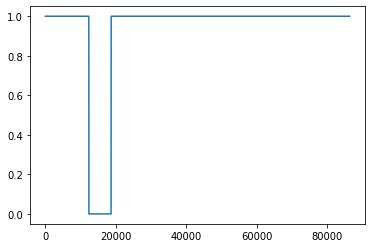

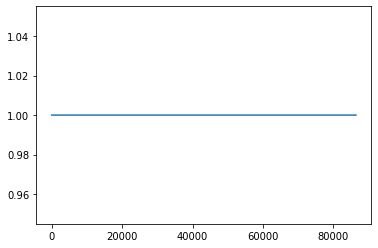

In [ ]:
plt.plot(mg1._grid_status_ts[0:DAY])
plt.show()
plt.plot(mg0._grid_status_ts[0:DAY])
plt.show()

41.96715714824922


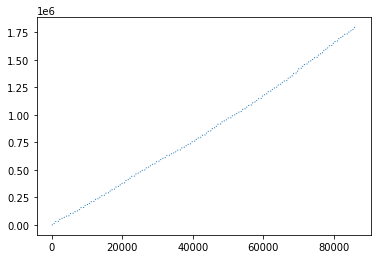

In [ ]:
df_cost_record = pd.DataFrame(cost_record)
print(cost_record[60])
plt.plot(df_cost_record[0:DAY], linestyle='dotted',
         label='line1', linewidth=1)
plt.show()